In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat

## Motivating Kernel Density Estimation: Histograms

As mentioned previously, a density estimator is an algorithm that seeks to model the probability distribution that generated a dataset.
For one-dimensional data, you are probably already familiar with one simple density estimator: the histogram.
A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions:

In [2]:
def make_data(N):
    rand = np.random.RandomState(1)
    N1 = int(0.3 * N)  # 30% of the data
    N2 = N - N1        # Remaining 70% of the data

    # Generate two separate Gaussian distributions
    x1 = rand.randn(N1)            # First Gaussian (mean=0, std=1)
    x2 = rand.randn(N2) + 5        # Second Gaussian (mean=5, std=1)

    # Combine the data
    return np.concatenate([x1, x2])

x_1000 = make_data(1000)

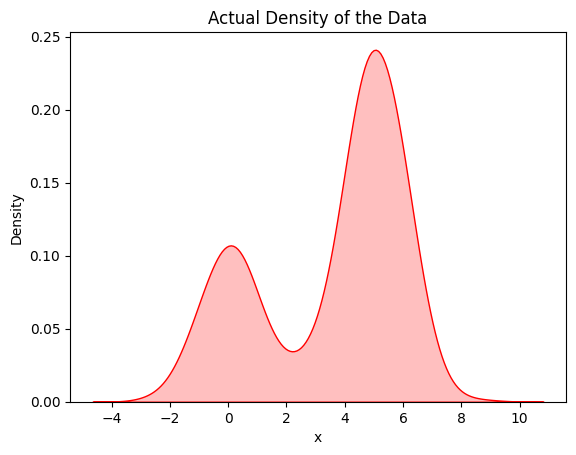

In [3]:

import seaborn as sns
sns.kdeplot(x_1000, fill=True, color='red', label='Actual Density')

plt.title("Actual Density of the Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

We have previously seen that the standard count-based histogram can be created with the `plt.hist` function.
By specifying the `density` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density (see the following figure):

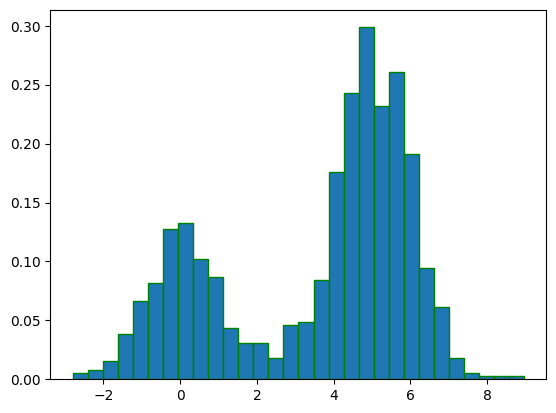

In [4]:
hist = plt.hist(x_1000, bins=30, density=True,edgecolor='green')

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.
For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!
Consider this example, visualized in the following figure:

(array([0.  , 0.06, 0.06, 0.06, 0.06, 0.27, 0.09, 0.  , 0.  ]),
 array([-4.4       , -2.73333333, -1.06666667,  0.6       ,  2.26666667,
         3.93333333,  5.6       ,  7.26666667,  8.93333333, 10.6       ]),
 <BarContainer object of 9 artists>)

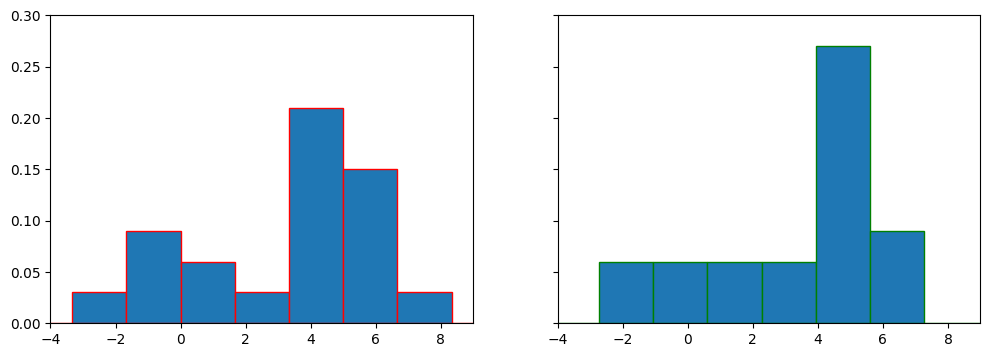

In [5]:
data = make_data(20)
bin_edges = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9), 'ylim':(0, 0.3)})

ax[0].hist(data, bins=bin_edges , density=True,edgecolor='red')
offset = 0.6;
ax[1].hist(data, bins=bin_edges+offset , density=True,edgecolor='green')


Bin edges play a crucial role

# Box Kernal

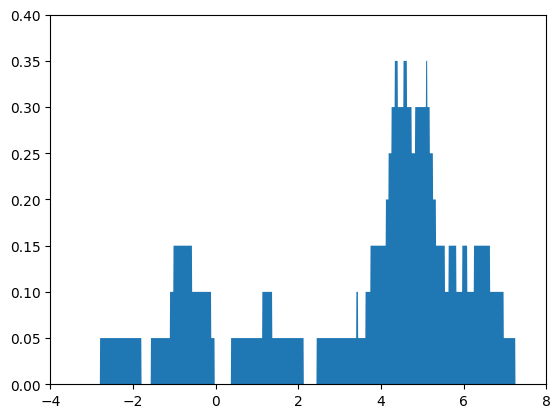

In [6]:
x = np.linspace(-4, 8, 2000)  # points at which we place the box kernal

 # Box kernal with h = 1
box_kernal = sum((abs(x  - x_n) < 0.5) for x_n in data)
density = box_kernal / len(data)

plt.fill_between(x, density)
plt.axis([-4, 8, 0, 0.4]);

Dicontinuities due to box kernal

# Gaussian Kernal

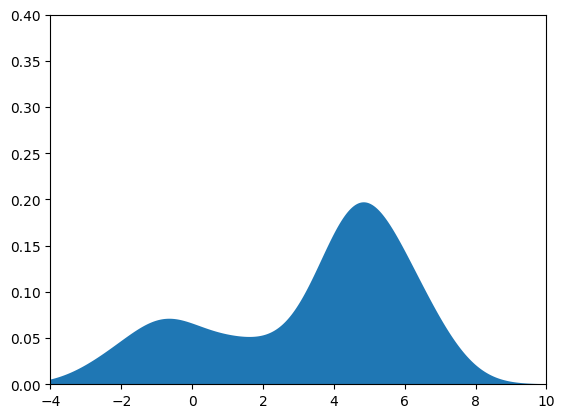

In [7]:
from scipy.stats import norm

x = np.linspace(-4, 10, 1000) # points at which we place the kernal

# norm(x_n): Creates an instance of the norm class with mean x_n
#.pdf(x): Calculates the probability density function (PDF) at points in x.
# sum(...): Sums up the PDF values to generate the overall kernel density estimate.

# Gaussian kernal with h =1
Gaussian_kernal = sum(norm(x_n).pdf(x) for x_n in data)
Gauss_kde = Gaussian_kernal / len(data)

plt.fill_between(x, Gauss_kde)

plt.axis([-4, 10, 0, 0.4]);

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for kernel density estimation: in particular, the Scikit-Learn KDE implementation supports six kernels, which you can read about in the ["Density Estimation" section](http://scikit-learn.org/stable/modules/density.html) of the documentation.

While there are several versions of KDE implemented in Python (notably in the SciPy and `statsmodels` packages), I prefer to use Scikit-Learn's version because of its efficiency and flexibility.
It is implemented in the `sklearn.neighbors.KernelDensity` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters.
The kernel bandwidth can be determined using Scikit-Learn's standard cross-validation tools, as we will soon see.

Let's first show a simple example of replicating the previous plot using the Scikit-Learn `KernelDensity` estimator (see the following figure):

In [8]:
from sklearn.neighbors import KernelDensity
x = np.linspace(-4, 10, 1000) # points at which we place the kernal

# instantiate and fit the KDE model
# h parameter is referred as bandwidth
kde = KernelDensity(bandwidth=1.12, kernel='gaussian')

# data is one dimensional data
# kde expects a two dimensionsl data
# data[:, None] is two dimenstional each row having one value

print(data)
print(data[:, None])

kde.fit(data[:, None])

[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  6.74481176  4.2387931   5.3190391   4.75062962  6.46210794  2.93985929
  4.6775828   4.61594565  6.13376944  3.90010873  4.82757179  4.12214158
  5.04221375  5.58281521]
[[ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 [-1.07296862]
 [ 0.86540763]
 [-2.3015387 ]
 [ 6.74481176]
 [ 4.2387931 ]
 [ 5.3190391 ]
 [ 4.75062962]
 [ 6.46210794]
 [ 2.93985929]
 [ 4.6775828 ]
 [ 4.61594565]
 [ 6.13376944]
 [ 3.90010873]
 [ 4.82757179]
 [ 4.12214158]
 [ 5.04221375]
 [ 5.58281521]]


,bandwidth,1.12
,algorithm,'auto'
,kernel,'gaussian'
,metric,'euclidean'
,atol,0
,rtol,0
,breadth_first,True
,leaf_size,40
,metric_params,None


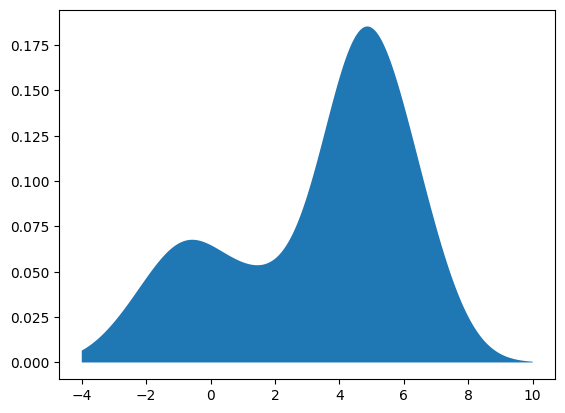

In [9]:
# Get log density and convert to probability density
log_density = kde.score_samples(x[:, None])  # Log density
density = np.exp(log_density)       # Convert to density

plt.fill_between(x, density)
#plt.ylim(0, 0.22);

The result here is normalized such that the area under the curve is equal to 1.

## Selecting the Bandwidth via Cross-Validation

Density estimate: Sensitive to the choice of bandwidth
Very small bandwidth: Overfitting
Very high bandwidth: Underfitting

Bandwidth tuning: Cross-validation approach.
Scikit-Learn's `KernelDensity` estimator
Designed to directly to standard grid search to find the optimal bandwidth

`GridSearchCV`Optimizes the bandwidth for a given dataset.

Leave-one-out cross-validation

For a dataset with n data points:
    Select one data point as the validation set.
    Use the remaining n−1n−1 data points to train the model.

Repeat the process n times, with each data point used as the validation set once.
Calculate the performance metric for each iteration.
Average the performance metrics across all n iterations to get the final estimate.


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
print(bandwidths)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(data[:, None]);

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124   4.32876128  4.

Now we can find the choice of bandwidth that maximizes the score (which in this case defaults to the log-likelihood):

In [11]:
grid.best_params_

{'bandwidth': np.float64(1.1233240329780276)}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0